In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.filters import gaussian, meijering, threshold_otsu
from skimage import exposure, morphology
from skimage.morphology import binary_closing, disk, skeletonize

In [4]:
# 1. 读图 & 灰度
img = imread("/Users/yanyanru/desktop/BIA/40X_sampled_png/egfr_F_L_oly_4X_8_cropped.png") [::2,::2] 
if img.ndim == 3:
    gray = rgb2gray(img)
else:
    gray = img.astype("float32")
    gray = (gray - gray.min()) / (gray.max() - gray.min() + 1e-8)

# 2. 轻微平滑，压掉毛刺和细纹理（sigma 可以再调）
smooth = gaussian(gray, sigma=1.0)

# 3. Meijering 脊线滤波，增强线状结构（主翅脉）
vein_resp = meijering(
    smooth,
    sigmas=range(2, 8),   # 线宽 2~7 像素，对主翅脉比较合适
    black_ridges=True
)

In [5]:
# 归一化到 0~1，方便阈值
vein_resp = exposure.rescale_intensity(vein_resp, out_range=(0, 1))

# 4. 强阈值（二段式：先 Otsu，再人为抬高一点）
th_otsu = threshold_otsu(vein_resp)
factor = 0.5           # 1.5~2 之间可以自己试
binary = vein_resp > (th_otsu * factor)

# 5. 形态学处理：闭运算连接小断点 + 去掉小连通域
binary = binary_closing(binary, disk(2))           # 填小缝
clean = morphology.remove_small_objects(binary,    # 去掉小碎片
                                         min_size=200)

# 6. 骨架化：变成 1 像素宽的翅脉线
skeleton = skeletonize(clean)

# 7. 提取散点坐标
# skeleton 中 True 的像素就是翅脉点
ys, xs = np.nonzero(skeleton)        # 注意顺序：(row, col) = (y, x)

# 保存为 x,y 格式的 CSV
coords = np.column_stack([xs, ys])   # [N,2]，第1列x,第2列y
df = pd.DataFrame(coords, columns=["x", "y"])
df.to_csv("wing_vein_points.csv", index=False)
print(f"共提取 {len(coords)} 个翅脉散点，已保存到 wing_vein_points.csv")

共提取 3732 个翅脉散点，已保存到 wing_vein_points.csv


/var/folders/dr/50hqbf2x5_179mx7lhv5262m0000gn/T/ipykernel_7523/3783533407.py:20: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/dr/50hqbf2x5_179mx7lhv5262m0000gn/T/ipykernel_7523/3783533407.py:20: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/dr/50hqbf2x5_179mx7lhv5262m0000gn/T/ipykernel_7523/3783533407.py:20: UserWarning: Glyph 28784 (\N{CJK UNIFIED IDEOGRAPH-7070}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/dr/50hqbf2x5_179mx7lhv5262m0000gn/T/ipykernel_7523/3783533407.py:20: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/dr/50hqbf2x5_179mx7lhv5262m0000gn/T/ipykernel_7523/3783533407.py:20: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/dr/50hqbf2x5

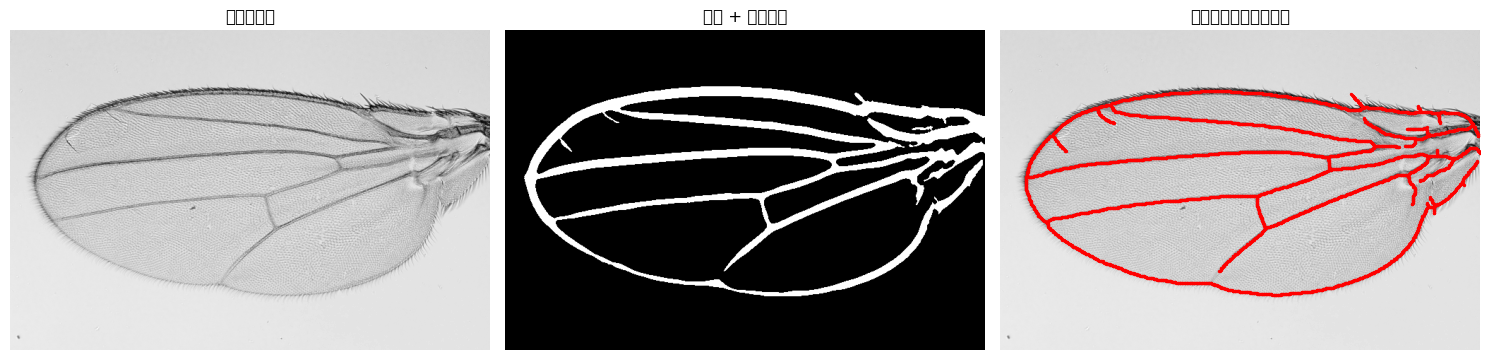

In [6]:
# 8. 简单可视化看看效果
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.imshow(gray, cmap="gray")
plt.title("原始灰度图")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(clean, cmap="gray")
plt.title("二值 + 去噪结果")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(gray, cmap="gray")
plt.scatter(xs, ys, s=2,c="r")  # 散点覆盖在图上
plt.title("翅脉散点坐标（骨架）")
plt.axis("off")

plt.tight_layout()
plt.show()